<a href="https://colab.research.google.com/github/Pini2001/retinopathy/blob/main/Preprocesado_y_extracci%C3%B3n_de_car%C3%A1cter%C3%ADsticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-colab

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from PIL import Image
from skimage import data, io, color
import sys
import cv2
from cv2 import cvtColor
from skimage.feature import greycomatrix, greycoprops

In [8]:
train_csv = '/content/drive/MyDrive/train.csv'
train_images= '/content/drive/MyDrive/train_images.zip'

In [9]:
with ZipFile('/content/drive/MyDrive/train_images.zip', 'r') as zip_ref:
    # Loop through all files in the zip file
    for filename in zip_ref.namelist():
        # Check if the file is an image (you may want to adjust this based on your image file types)
        if filename.endswith('.png'):
            # Extract the image file to a temporary location if the directory 'DR' doesn't already exist
            if not os.path.exists('DR'):
                os.makedirs('DR')
                zip_ref.extract(filename, path='DR')
            else:
                if not os.path.exists(f'DR/{filename}'):
                    zip_ref.extract(filename, path='DR')

In [10]:
train = pd.read_csv(train_csv, delimiter=',')
#Creating column 
train['labels']= np.where(train['diagnosis'] == 0, 'No', 'Si')
train.dataframeName = 'train.csv'
nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set')
#len(df.columns)
train.head()

There are 3662 rows and 3 columns in the training set


,id_code,diagnosis,labels
0,000c1434d8d7,2.0,Si
1,001639a390f0,4.0,Si
2,0024cdab0c1e,1.0,Si
3,002c21358ce6,0.0,No
4,005b95c28852,0.0,No


# GLCM

In [11]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage.feature import greycomatrix, greycoprops
import pandas as pd

# Define the GLCM parameters
distance = [1]
directory = 'DR'
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
properties = ['correlation', 'homogeneity', 'contrast', 'energy', 'dissimilarity']

# Create an empty list to store the texture features
texture_features = []

# Loop over all the images in the directory
for filename in os.listdir(directory):
    # Read the image
    filepath = os.path.join(directory, filename)
    if os.path.isfile(filepath) and os.path.splitext(filepath)[1].lower() in ['.png']:
       with Image.open(filepath) as img:
        # Resize and preprocess the image
        output_size = (224, 224)
        resized_img = img.copy().resize(output_size)
        gray_img = cv2.cvtColor(np.array(resized_img), cv2.COLOR_BGR2GRAY)
        equalized_img = cv2.equalizeHist(gray_img)
        blur = cv2.GaussianBlur(equalized_img, (5,5), 0)
        thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # Compute the GLCM and the texture features
        glcm_mat = greycomatrix(thresh, distances=distance, angles=angles, symmetric=True, normed=True)
        block_glcm = np.hstack([greycoprops(glcm_mat, props).ravel() for props in properties])

        # Append the texture features with the angles and property names
        for i, prop in enumerate(properties):
            for j, ang in enumerate(angles):
                texture_features.append(block_glcm[i*len(angles)+j])
        texture_features.append(filename)
        
        # Convert NumPy array to PIL Image object
        thresh_img = Image.fromarray(thresh)
        
        # Save preprocessed image
        os.makedirs(os.path.join(directory, "Preprocessed_images"), exist_ok=True)
        thresh_img.save(os.path.join(directory, "Preprocessed_images", filename))
        
# Create the pandas DataFrame for GLCM features data
columns = []
for name in properties:
    for ang in angles:
        columns.append(name + "_" + str(int(np.rad2deg(ang))))
columns.append("filename")

glcm_df = pd.DataFrame(np.array(texture_features).reshape(-1, 21), columns=columns)


Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_ve

In [12]:
print(glcm_df.head(10))

        correlation_0      correlation_45      correlation_90  \
0  0.8997419820518922   0.880310601798506  0.9281676770222217   
1  0.9447264567093809  0.9301500271096678   0.948416113885774   
2   0.933820319240614  0.9186682358923381  0.9553383377050021   
3  0.9283257374747083  0.9154070434660224  0.9521505386271395   
4  0.9333398445042309  0.9218209412260169  0.9557283211279036   
5  0.9525806306305853  0.9376737071650497  0.9478951538124106   
6  0.9181538144198431  0.9071316503181766  0.9490239823652337   
7  0.9558259433516056   0.947486944856008  0.9746690615880651   
8  0.9467882791063685  0.9227814178627248  0.9415833725220734   
9  0.9707450646807217  0.9591172278876189  0.9699273801531643   

      correlation_135       homogeneity_0      homogeneity_45  \
0  0.8761279077753357  0.9498726478954567   0.940156563902529   
1  0.9250802710127887  0.9723739033928636  0.9650913289431419   
2  0.9262339813907254  0.9669287597137758  0.9593603547200977   
3  0.9133153488679402   

# Visualización

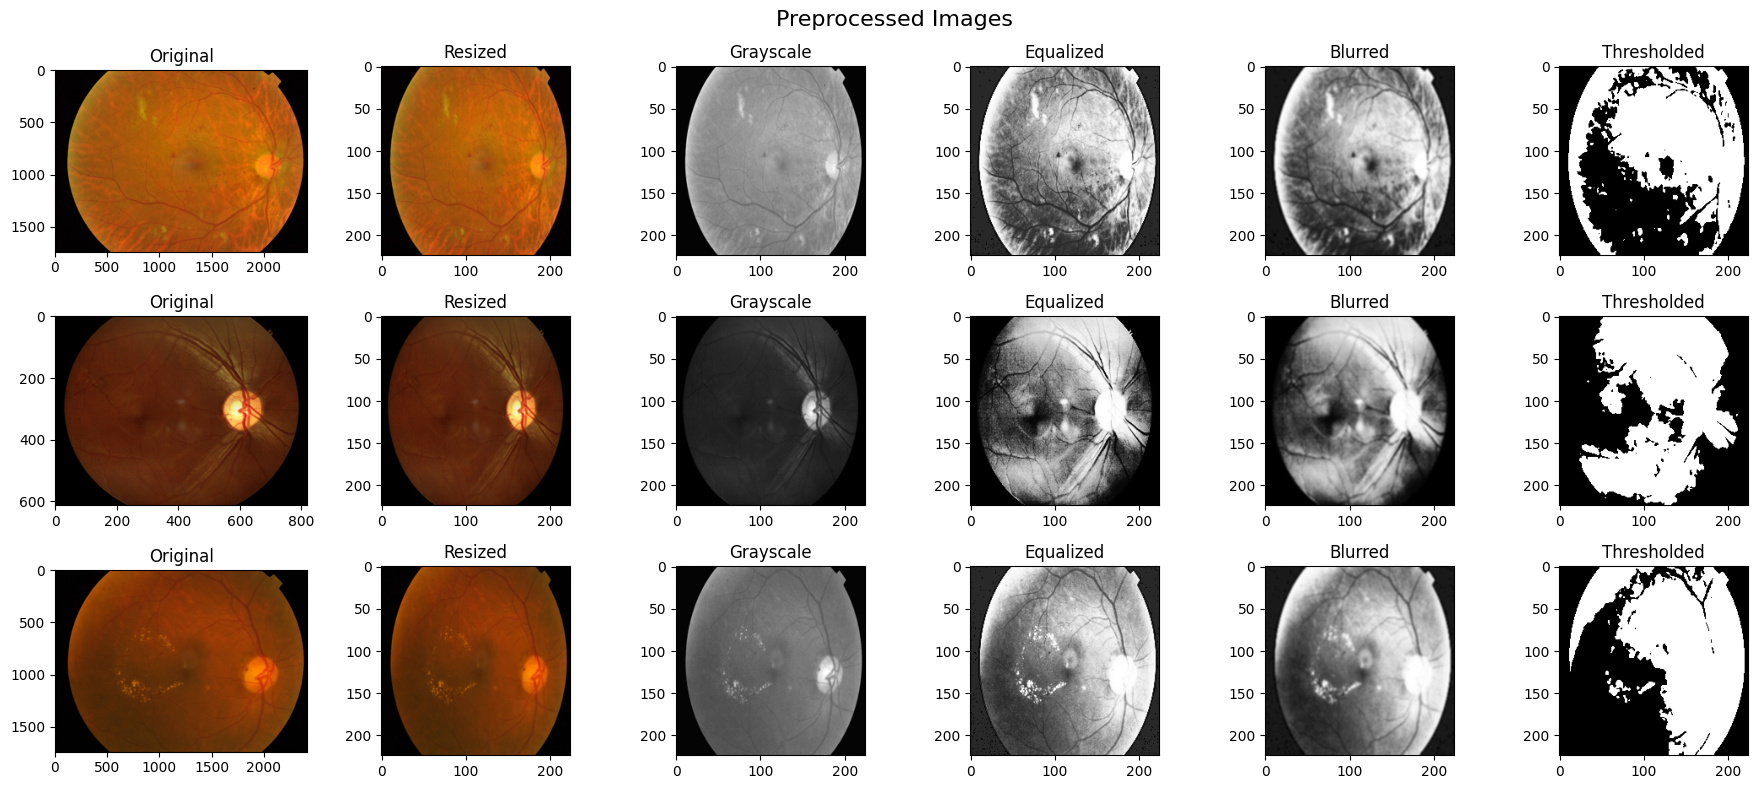

In [13]:
import os
import matplotlib.pyplot as plt

directory = 'DR'

# Select the first three images in the directory
image_files = os.listdir(directory)[:3]

# Create a subplot with 6 columns (for each preprocess method) and 3 rows (for each image)
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(18, 8))

for i, filename in enumerate(image_files):
    filepath = os.path.join(directory, filename)
    with Image.open(filepath) as img:
        
        # Display the original image in the first column
        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Original')
        
        # Resize the image and display it in the second column
        output_size = (224, 224)  # optimal input size
        #resized_img = cv2.resize(img, output_size)
        resized_img = img.copy().resize(output_size)
        axs[i, 1].imshow(resized_img)
        axs[i, 1].set_title('Resized')
        
        # Convert the image to grayscale and display it in the third column
        gray_img = cv2.cvtColor(np.array(resized_img), cv2.COLOR_BGR2GRAY)
        axs[i, 2].imshow(gray_img, cmap='gray')
        axs[i, 2].set_title('Grayscale')
        
        # Apply histogram equalization and display it in the fourth column
        equalized_img = cv2.equalizeHist(gray_img)
        axs[i, 3].imshow(equalized_img, cmap='gray')
        axs[i, 3].set_title('Equalized')
        
        # Apply Gaussian blur and display it in the fifth column
        blur = cv2.GaussianBlur(equalized_img, (5,5), 0)
        axs[i, 4].imshow(blur, cmap='gray')
        axs[i, 4].set_title('Blurred')

        # Apply thresholding and display it in the sixth column
        #thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        #thresh = cv2.threshold(blur, 240, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        axs[i, 5].imshow(thresh, cmap='gray')
        axs[i, 5].set_title('Thresholded')
      

# Set the title of the subplot
fig.suptitle('Preprocessed Images', fontsize=16)

# Adjust the spacing between the subplots
plt.tight_layout()

# Display the subplot
plt.show()